In [ ]:
# import sys
# sys.path.append("../")

# from digitalhistopathology.datasets.real_datasets import HER2Dataset, TNBCDataset
# from digitalhistopathology.embeddings.gene_embedding import GeneEmbedding


# patches_folder = "/idiap/temp/lfournier/repositories/digitalhistopathology/results/compute_patches/TNBC_fixed"
# gene_embedding_saving_path = "/idiap/temp/lfournier/repositories/digitalhistopathology/results/molecular/TNBC"
# gene_counts_path = "/idiap/temp/group/genomics/albin/digitalhistopathology/results/TNBC/count-matrices"
# dataDir = "/idiap/resource/database/ST_TNBC_v3"


# d = TNBCDataset(patches_folder=patches_folder, 
#                 saving_emb_folder=gene_embedding_saving_path,
#                 gene_counts_path=gene_counts_path, 
#                 dataDir=dataDir,)


# ge = GeneEmbedding(
#     spot_diameter_fullres=d.spot_diameter,
#     samples_names=d.samples_names,
#     genes_count_filenames=d.genes_count_filenames,
#     spots_filenames=d.genes_spots_filenames,
#     image_filenames=d.images_filenames,
#     label_files=d.label_filenames,
#     patches_filenames=d.patches_filenames,
#     name=d.name,
#     st_method="old_st",
# )

2025-10-01 17:33:04.792705: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /storage/homefs/lf25x455/.conda/envs/digitalhisto/lib/python3.10/site-packages/cv2/../../lib64:/storage/homefs/lf25x455/.conda/envs/digitalhisto/lib/python3.10/site-packages/cv2/../../lib64:
2025-10-01 17:33:04.792835: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /storage/homefs/lf25x455/.conda/envs/digitalhisto/lib/python3.10/site-packages/cv2/../../lib64:/storage/homefs/lf25x455/.conda/envs/digitalhisto/lib/python3.10/site-packages/cv2/../../lib64:
2025-10-01 17:33:04.792843: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


/storage/homefs/lf25x455/.conda/envs/digitalhisto/lib/python3.10/site-packages/stlearn/tl/cci/het.py:206: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(parallel=True, nopython=False)


In [ ]:
import array
from PIL import Image
from json import load
import pandas as pd
import rpy2.robjects as ro
import rpy2.robjects.vectors as rvec
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
import numpy as np
import matplotlib.pyplot as plt
Image.MAX_IMAGE_PIXELS = None

# Load EBImage package from R
EBImage = importr('EBImage')
def convert_to_df(data):
    # Check if data is an R Matrix
    if isinstance(data, rvec.Matrix):
        return pandas2ri.rpy2py(ro.r['as.data.frame'](data))
    elif isinstance(data, rvec.Vector):
        return pandas2ri.rpy2py(data)
    # Check if data is an R DataFrame
    elif isinstance(data, rvec.DataFrame):
        return pandas2ri.rpy2py(data)

    # Check if data is an EBImage object (matrix or image)
    elif isinstance(data, ro.rinterface.Sexp):
        # Check if it's an EBImage object (usually matrix)
        try:
            ro.r('library(EBImage)')
            image_array = ro.r['imageData'](data)  # Convert EBImage object to matrix
            if isinstance(image_array, rvec.Matrix):
                # Convert the image matrix to a DataFrame (pixel values)
                return pd.DataFrame(pandas2ri.rpy2py(image_array))
        except Exception as e:
            print(f"Error converting EBImage object: {e}")
            return None

    # Return None for unsupported data types
    else:
        return None

In [ ]:
from gtfparse import read_gtf
annotation = read_gtf("/storage/research/dbmr_luisierlab/group/genomics/annotation/hg38/GENCODE/gencode.v38.annotation.gtf")
annotation = annotation.to_pandas()

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'hgnc_id', 'havana_gene', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'tag', 'havana_transcript', 'exon_number', 'exon_id', 'ont', 'protein_id', 'ccdsid']


In [ ]:
annotated_genes = list(annotation['gene_name'].unique())

In [ ]:
import rpy2.robjects as robjects
import os 

file = "/storage/research/dbmr_luisierlab/database/ST_TNBC_v3/Robjects/countsNonCorrected/TNBC1.RDS"
count_matrices = []
# for file in ["/storage/research/dbmr_luisierlab/database/ST_TNBC_v3/Robjects/countsNonCorrected/TNBC79.RDS",
#              "/storage/research/dbmr_luisierlab/database/ST_TNBC_v3/Robjects/countsNonCorrected/TNBC64.RDS"]:
df = robjects.r['readRDS'](file)
filename = os.path.basename(file).replace(".RDS", "")
spots_df = convert_to_df(df)

# Extract the count matrix from the RDS ListVector
counts_matrix = df.rx2('cnts')  # Extract the 'cnts' element

# Convert the count matrix to a pandas DataFrame
counts_df = convert_to_df(counts_matrix)
detected_genes = list(counts_df.columns) 
detected_annotated_genes = list(set(detected_genes).intersection(set(annotated_genes)))

print(f"Number of detected genes: {len(detected_genes)}")
print(f"Number of annotated genes: {len(annotated_genes)}")
print(f"Number of detected & annotated genes: {len(detected_annotated_genes)}")

annotated_protein_coding_genes = annotation[annotation['gene_type'] == 'protein_coding']['gene_name'].unique().tolist()

detected_annotated_protein_coding_genes = list(set(detected_genes).intersection(set(annotated_protein_coding_genes)))

print(f"Number of detected genes: {len(detected_genes)}")
print(f"Number of annotated protein-coding genes: {len(annotated_protein_coding_genes)}")
print(f"Number of detected & annotated protein-coding genes: {len(detected_annotated_protein_coding_genes)}")

df_counts_coding = counts_df[detected_annotated_protein_coding_genes]

df_counts_coding = counts_df[detected_annotated_protein_coding_genes]

df_counts_coding.index = [f"{filename}" for idx in df_counts_coding.index]

# count_matrices.append(df_counts_coding)

Number of detected genes: 32145
Number of annotated genes: 59385
Number of detected & annotated genes: 29193
Number of detected genes: 32145
Number of annotated protein-coding genes: 19930
Number of detected & annotated protein-coding genes: 16509


In [ ]:
pseudobulk = df_counts_coding.sum(axis=0).sort_values(ascending=False)

In [ ]:
pseudobulk_log = np.log2(1 + pseudobulk)

In [ ]:
pseudobulk_log = pseudobulk_log[pseudobulk_log > 0]

Text(0, 0.5, 'Number of genes')

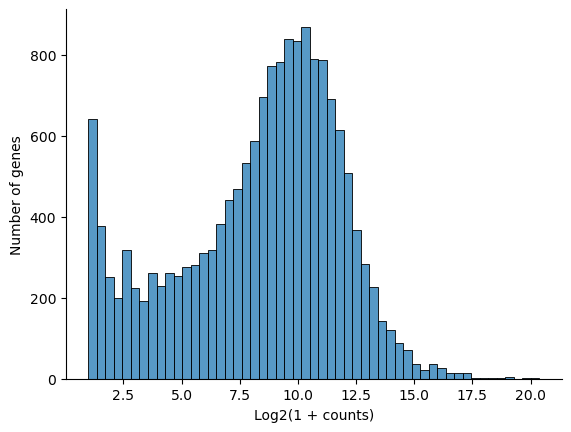

In [ ]:
import seaborn as sns
sns.histplot(pseudobulk_log)
sns.despine()
plt.xlabel("Log2(1 + counts)")
plt.ylabel("Number of genes")
plt.title(f"{filename} - {len(pseudobulk_log)} genes", weight='bold')